# Comparin Inline Data and Converted CTD Fluorescence at the surface

**Author:** Mathurin Choblet (mchoblet@uliege.be)

**Date:** 25.11.2025


In [1]:
import xarray as xr
import glob
import numpy as np
import os, re
import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as GridSpec
from matplotlib.ticker import FuncFormatter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy import stats

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import seaborn as sns
import matplotlib.patches as patches
import pandas as pd
sns.set_context('talk')
land = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])

# Load CTD data

-> See CTD_postprocessing script

In [2]:
ctd_paths=sorted(glob.glob('/home/mathu/otc25_project/data_nc/*.nc'))

# Load Inline System data (comes in UTC time)

In [5]:
#load inline system as well (30 minutes around station)
df1=pd.read_csv('/home/mathu/prod/Leg03/OneOcean_InLine_ACS_20250423_20250505_Products_full_Leg03_v20250530.csv')[['dt','lat','lon','Chl_lineheight']]
df2=pd.read_csv('/home/mathu/prod/Leg04/OneOcean_InLine_ACS_20250508_20250602_Products_Leg04_v20250603.csv')[['dt','lat','lon','Chl_lineheight']]

times=np.concatenate([df1['dt'].values,df2['dt'].values])
vals=np.concatenate([df1['Chl_lineheight'],df2['Chl_lineheight']])
lats=np.concatenate([df1['lat'],df2['lat']])
lons=np.concatenate([df1['lon'],df2['lon']])
inline=xr.Dataset(data_vars={'CHL':('time',vals),'lat':('time',lats),'lon':('time',lons)},coords={'time':times})

times=[np.datetime64(t) for t in times]
inline['time']=times

/tmp/ipykernel_11350/1843910192.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  inline['time']=times
/tmp/ipykernel_11350/1843910192.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead 

In [7]:
inline.to_netcdf('inline_system_full_CHLa_only.nc')

# matching ctd fluoresence and inline system

* uncertainties:
      - ctd cast: currently take first (deepest), but some times multiple values

In [6]:
unique_paths=sorted([p for p in ctd_paths if 'CAST1' in p])

In [7]:
time_windows = {
    "Norwegian Sea": [("2025-04-20","2025-05-05"),"#87CEEB"],
    "North Atlantic": [("2025-05-05","2025-05-25"),"#9ACD32"],
    "Med. Sea": [("2025-05-25","2025-06-05"),"#FF7F50"]
}

td=datetime.timedelta(minutes=60)

#INLINE - CTD
IC_inline=[]
IC_ctd=[]

points=[[],[],[]]


for i,p in enumerate(unique_paths):
    idx=p.find('_ST')
    k=(p[(idx+3):(idx+5)])
    vv=xr.open_dataset(p)
    
    start=pd.to_datetime(vv['time'].values.item())-td
    end=pd.to_datetime(vv['time'].values.item())+td
    in_val=inline['CHL'].sel(time=slice(start,end)).mean().values.item()
    ctd_val=vv['fluorescence_xing'].sel(depth=0,method='nearest').values.item()
    IC_inline.append(in_val)
    IC_ctd.append(ctd_val)

    vv=vv['time'].values
    for j,(v,k) in enumerate(time_windows.items()):
        if (vv>=pd.to_datetime(k[0][0])) & (vv<pd.to_datetime(k[0][1])):
            points[j].append(i)

nor,na,med=points
attr_0={"Norwegian Sea": [nor,"#87CEEB"],"North Atlantic": [na,"#9ACD32"],"Med. Sea": [med,"#FF7F50"]}

IC_inline=np.array(IC_inline)
IC_ctd=np.array(IC_ctd)


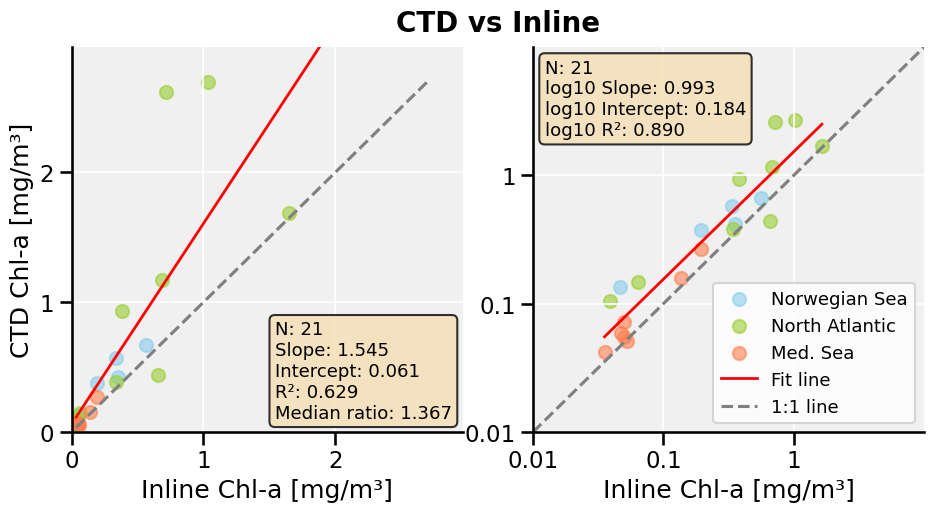

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import MaxNLocator

# ---------- helpers ----------
def _common_look(ax):
    ax.set_facecolor("#F0F0F0")
    ax.grid(True, color="white", linewidth=1.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.minorticks_off()

def _stats_box(ax, text, fontsize=13, x=0.03, y=0.97):
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(x, y, text, transform=ax.transAxes, fontsize=fontsize,
            va='top', ha='left', bbox=props)

def _row_title(fig, axes_row, title, fontsize=14, ypad=0.02):
    """Place a row title centered above both subplots in that row."""
    left = min(ax.get_position().x0 for ax in axes_row)
    right = max(ax.get_position().x1 for ax in axes_row)
    top = max(ax.get_position().y1 for ax in axes_row)
    x = (left + right) / 2.0
    y = top + ypad
    fig.text(x, y, title, ha='center', va='bottom',
             fontsize=fontsize, weight='bold')

def _create_comparison_panel(ax, x, y, xlab, ylab, scale='linear', 
                             show_legend=False, show_ylabel=True, ms=90):
    """
    Create a single comparison panel (linear or log scale).
    
    Parameters:
    -----------
    scale : str, 'linear' or 'log'
    show_ylabel : bool, whether to show y-axis label
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Filter valid data
    if scale == 'log':
        mask = (~np.isnan(x)) & (~np.isnan(y)) & (x > 0) & (y > 0)
    else:
        mask = (~np.isnan(x)) & (~np.isnan(y))
    
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Scatter plot with attributes
    for k, v in attr_0.items():
        ax.scatter(x[v[0]], y[v[0]], s=ms, alpha=0.6, label=k, color=v[1])
    
    # Configure scale and limits
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(0.01, 10)
        ax.set_ylim(0.01, 10)
        ticks = [0.01, 0.1, 1]
        ax.set_xticks(ticks)
        ax.set_xticklabels(["0.01", "0.1", "1"])
        ax.set_yticks(ticks)
        ax.set_yticklabels(["0.01", "0.1", "1"])
        ax.minorticks_off()
        
        # Regression in log space
        lx, ly = np.log10(x_clean), np.log10(y_clean)
        slope, intercept, r_value, _, _ = stats.linregress(lx, ly)
        a10 = 10 ** intercept
        
        # Fit line
        xmin = max(0.01, float(x_clean.min()))
        xmax = min(10.0, float(x_clean.max()))
        if xmax > xmin:
            xx = np.logspace(np.log10(xmin), np.log10(xmax), 200)
            ax.plot(xx, a10 * (xx ** slope), 'r-', linewidth=2, label='Fit line')
        
        # 1:1 line
        xx = np.logspace(-2, 1, 200)
        ax.plot(xx, xx, linestyle='--', color='gray', alpha=1, label='1:1 line')
        
        # Stats text
        stats_text = (
            f"N: {len(x_clean)}\n"
            f"log10 Slope: {slope:.3f}\n"
            f"log10 Intercept: {intercept:.3f}\n"
            f"log10 R²: {r_value**2:.3f}"#\n"
            #f"Median ratio: {np.median(ly/lx):.3f}"
        )
        stats_x, stats_y = 0.03, 0.97
        
    else:  # linear
        # Regression in linear space
        slope, intercept, r_value, _, _ = stats.linregress(x_clean, y_clean)
        
        # Set limits
        xmin = float(np.min(x_clean))
        xmax = float(np.nanmax([x_clean, y_clean]))
        ax.set_xlim(0, xmax * 1.1)
        ax.set_ylim(0, xmax * 1.1)
        
        # Fit line
        if xmax > xmin:
            xs = np.linspace(xmin, xmax, 200)
            ax.plot(xs, slope * xs + intercept, 'r-', linewidth=2, label='Fit line')
        
        # 1:1 line
        one_min = float(np.nanmin([x_clean, y_clean]))
        one_max = float(np.nanmax([x_clean, y_clean]))
        ax.plot([one_min, one_max], [one_min, one_max], 
                linestyle='--', color='gray', alpha=1, label='1:1 line')
        
        # 3 ticks for linear scale
        ax.xaxis.set_major_locator(MaxNLocator(3))
        ax.yaxis.set_major_locator(MaxNLocator(3))
        
        # Stats text
        stats_text = (
            f"N: {len(x_clean)}\n"
            f"Slope: {slope:.3f}\n"
            f"Intercept: {intercept:.3f}\n"
            f"R²: {r_value**2:.3f}\n"
            f"Median ratio: {np.median(y_clean/x_clean):.3f}"
        )
        stats_x, stats_y = 0.52, 0.29
    
    # Labels
    ax.set_xlabel(xlab)
    if show_ylabel:
        ax.set_ylabel(ylab)
    
    # Legend and stats
    if show_legend:
        ax.legend(loc='lower right', fontsize=13)
    
    _stats_box(ax, stats_text, x=stats_x, y=stats_y)

# ---------- main figure ----------
fig, (ax_lin, ax_log) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

xlab = "Inline Chl-a [mg/m³]"
ylab = "CTD Chl-a [mg/m³]"
row_title = "CTD vs Inline"

# Apply common styling
_common_look(ax_lin)
_common_look(ax_log)

# Create both panels
_create_comparison_panel(ax_lin, IC_inline, IC_ctd, xlab, ylab, 
                         scale='linear', show_legend=False, show_ylabel=True)
_create_comparison_panel(ax_log, IC_inline, IC_ctd, xlab, ylab, 
                         scale='log', show_legend=True, show_ylabel=False)

# Add row title
_row_title(fig, (ax_lin, ax_log), row_title, fontsize=20, ypad=0.02)

# Adjust spacing
fig.subplots_adjust(top=0.88, wspace=0.18)

plt.show()
#fig.savefig('ctd_vs_inline.png', bbox_inches='tight', dpi=300)

# Poster Plot

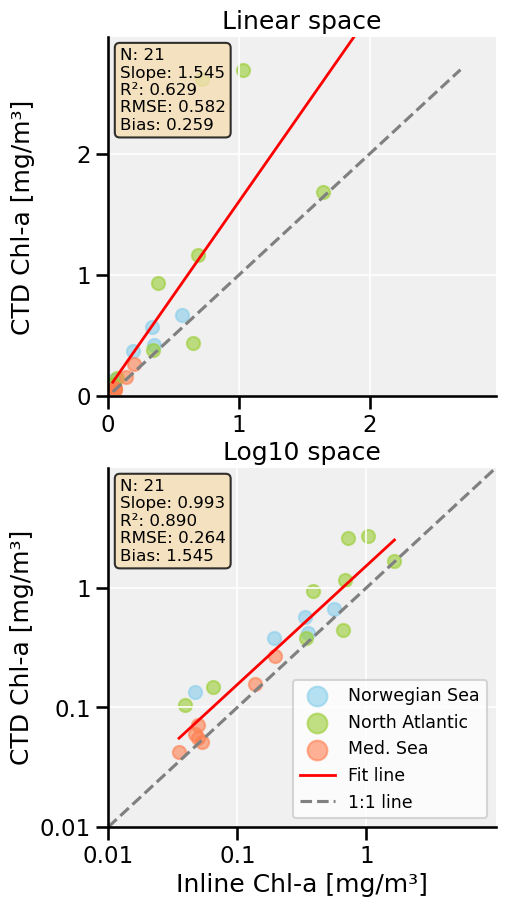

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import MaxNLocator

def regression_and_metrics(x_log, y_log):
    """OLS in log space + custom metrics (also in log space)."""
    if len(x_log) < 2:
        return dict(n=len(x_log), slope=np.nan, intercept=np.nan, r2=np.nan,
                    p=np.nan, stderr=np.nan, rmse=np.nan, mdad=np.nan, bias=np.nan)
    slope, intercept, r, p, stderr = stats.linregress(x_log, y_log)
    diff = y_log - x_log
    rmse = float(np.sqrt(np.mean(diff**2)))
    mdad = float(10 ** (np.median(np.abs(diff))))
    bias = float(10 ** (np.mean(diff)))
    return dict(n=len(x_log), slope=slope, intercept=intercept, r2=r**2,
                p=p, stderr=stderr, rmse=rmse, mdad=mdad, bias=bias)

# ---------- helpers ----------
def _common_look(ax):
    ax.set_facecolor("#F0F0F0")
    ax.grid(True, color="white", linewidth=1.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.minorticks_off()
    # match other figure's tick label size
    ax.tick_params(axis='both')

def _stats_box(ax, text, fontsize=12, x=0.03, y=0.97):
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(x, y, text, transform=ax.transAxes, fontsize=fontsize,
            va='top', ha='left', bbox=props)

def _create_comparison_panel(ax, x, y, xlab, ylab, scale='linear', 
                             show_legend=False, show_ylabel=True, ms=90,labelpad=None,show_xlabel=True):
    """
    Create a single comparison panel (linear or log scale).
    
    Parameters:
    -----------
    scale : str, 'linear' or 'log'
    show_ylabel : bool, whether to show y-axis label
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Filter valid data
    if scale == 'log':
        mask = (~np.isnan(x)) & (~np.isnan(y)) & (x > 0) & (y > 0)
    else:
        mask = (~np.isnan(x)) & (~np.isnan(y))
    
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Scatter plot with attributes (uses full arrays, not masked)
    for k, v in attr_0.items():
        ax.scatter(x[v[0]], y[v[0]], s=ms, alpha=0.6, label=k, color=v[1])
    
    if scale == 'log':
        # Configure scale and limits
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(0.01, 10)
        ax.set_ylim(0.01, 10)
        ticks = [0.01, 0.1, 1]
        ax.set_xticks(ticks)
        ax.set_xticklabels(["0.01", "0.1", "1"])
        ax.set_yticks(ticks)
        ax.set_yticklabels(["0.01", "0.1", "1"])
        ax.minorticks_off()
        
        # Regression and metrics in log space
        lx, ly = np.log10(x_clean), np.log10(y_clean)
        metrics = regression_and_metrics(lx, ly)
        slope = metrics["slope"]
        intercept = metrics["intercept"]
        r2 = metrics["r2"]
        rmse = metrics["rmse"]
        bias = metrics["bias"]
        a10 = 10 ** intercept
        
        # Fit line
        if np.isfinite(slope) and np.isfinite(intercept) and len(x_clean) >= 2:
            xmin = max(0.01, float(x_clean.min()))
            xmax = min(10.0, float(x_clean.max()))
            if xmax > xmin:
                xx = np.logspace(np.log10(xmin), np.log10(xmax), 200)
                ax.plot(xx, a10 * (xx ** slope), 'r-', linewidth=2, label='Fit line')
        
        # 1:1 line
        xx = np.logspace(-2, 1, 200)
        ax.plot(xx, xx, linestyle='--', color='gray', alpha=1, label='1:1 line')
        
        # Stats text
        stats_text = (
            f"N: {len(y_clean)}\n"
            f"Slope: {slope:.3f}\n"
            f"R²: {r2:.3f}\n"
            f"RMSE: {rmse:.3f}\n"
            f"Bias: {bias:.3f}"
        )
        stats_x, stats_y = 0.03, 0.97
        
    else:  # linear
        # Regression in linear space
        slope, intercept, r_value, _, _ = stats.linregress(x_clean, y_clean)
        
        # Set limits
        xmin = float(np.min(x_clean))
        xmax = float(np.nanmax([x_clean, y_clean]))
        ax.set_xlim(0, xmax * 1.1)
        ax.set_ylim(0, xmax * 1.1)
        
        # Fit line
        if xmax > xmin:
            xs = np.linspace(xmin, xmax, 200)
            ax.plot(xs, slope * xs + intercept, 'r-', linewidth=2, label='Fit line')
        
        # 1:1 line
        one_min = float(np.nanmin([x_clean, y_clean]))
        one_max = float(np.nanmax([x_clean, y_clean]))
        ax.plot([one_min, one_max], [one_min, one_max], 
                linestyle='--', color='gray', alpha=1, label='1:1 line')
        
        # 3 ticks for linear scale
        ax.xaxis.set_major_locator(MaxNLocator(3))
        ax.yaxis.set_major_locator(MaxNLocator(3))
        
        # Metrics in linear space
        diff = y_clean - x_clean
        rmse = float(np.sqrt(np.mean(diff**2)))
        bias = float(np.mean(diff))
        r2 = r_value**2
        
        stats_text = (
            f"N: {len(y_clean)}\n"
            f"Slope: {slope:.3f}\n"
            f"R²: {r2:.3f}\n"
            f"RMSE: {rmse:.3f}\n"
            f"Bias: {bias:.3f}"
        )
        stats_x, stats_y = 0.03, 0.97
    
    # Labels (matching other figure)
    if show_xlabel:
        ax.set_xlabel(xlab)
    if show_ylabel:
        ax.set_ylabel(ylab,labelpad=labelpad)
    
    # Legend and stats
    if show_legend:
        ax.legend(loc='lower right', fontsize=12.5,markerscale=1.5)
    
    _stats_box(ax, stats_text, x=stats_x, y=stats_y, fontsize=12)

# ---------- main figure ----------
fig, (ax_lin, ax_log) = plt.subplots(nrows=2, ncols=1, figsize=(5, 10),
                                     sharex=False, sharey=False)

xlab = "Inline Chl-a [mg/m³]"
ylab = "CTD Chl-a [mg/m³]"

# Apply common styling
_common_look(ax_lin)
_common_look(ax_log)

# Create both panels
_create_comparison_panel(ax_lin, IC_inline, IC_ctd, xlab, ylab, 
                         scale='linear', show_legend=False, show_ylabel=True,labelpad=30,show_xlabel=False)

_create_comparison_panel(ax_log, IC_inline, IC_ctd, xlab, ylab, 
                         scale='log', show_legend=True, show_ylabel=True)

# Titles per axis
ax_lin.set_title("Linear space", fontsize=18, pad=6)
ax_log.set_title("Log10 space", fontsize=18, pad=6)

# Figure-level suptitle
#fig.suptitle("CTD vs Inline (Linear / Log10 space)", fontsize=25, y=0.97)

# Adjust spacing
fig.subplots_adjust(top=0.90, hspace=0.2)

plt.show()
fig.savefig('ctd_vs_inline_poster.png', bbox_inches='tight', dpi=300)

# Inline vs CTD

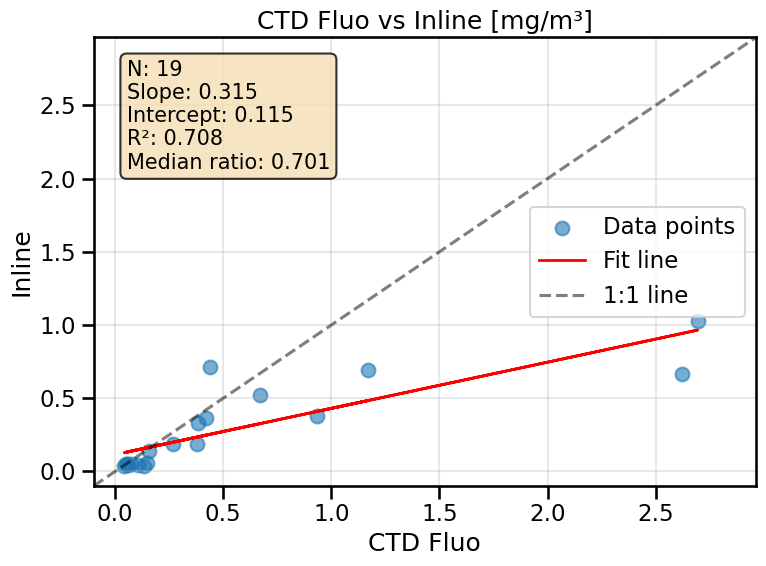

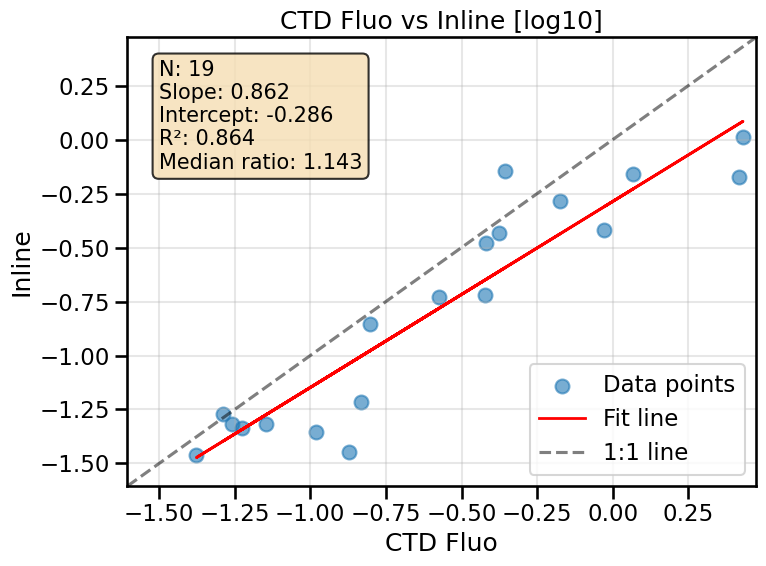

In [440]:
ms=100

scatterplot(IC_ctd,IC_inline,'CTD Fluo','Inline','CTD Fluo vs Inline [mg/m³]',ms=ms,lim=0)
scatterplot(np.log10(IC_ctd),np.log10(IC_inline),'CTD Fluo','Inline','CTD Fluo vs Inline [log10]',ms=ms)